<a href="https://colab.research.google.com/github/Vinicargui/DETECTRON2/blob/main/Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train Detectron2 on Custom Objects

This tutorial implements the new [Detectron2 Library](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/) by facebook. This notebook shows training on **your own custom objects** for object detection.

It is worth noting that the Detectron2 library goes far beyond object detection, supporting semantic segmentation, keypoint detection, mask, and densepose.


### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Detectron2](https://blog.roboflow.ai/how-to-train-detectron2/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Detectron2 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install Detectron2 dependencies
* Download custom Detectron2 object detection data
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Detectron2 performance
* Run Detectron2 inference on test images



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Install Detectron2 Dependencies

In [4]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 23 kB/s 
     |████████████████████████████████| 6.6 MB 44.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.5.0+cu101

In [5]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 676 kB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=1a146de32bab53eff744df26b69485c45f4ce2f46214bf8961f102caa9d6bb8c
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31548 sha256=90cf061fc7086b59ad5cb249f4efbd3bae6def8084a9789d319253c0cb60cb95
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84b9185196513ef2faf74a5a379b043a7
Successfully built fvcore iopath


In [6]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [7]:
!curl -L "https://public.roboflow.com/ds/XHm43jMRWK?key=49qzKDxDNP" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   892  100   892    0     0   1393      0 --:--:-- --:--:-- --:--:--  1393
100 1719k  100 1719k    0     0  2049k      0 --:--:-- --:--:-- --:--:-- 9147k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/chanterelle_02_jpg.rf.f7a48494b7393c532f641585d99a57be.jpg  
 extracting: test/chanterelle_03_jpg.rf.580f8d787af6a8050c21c065bf016f20.jpg  
 extracting: test/chanterelle_03_jpg.rf.cd892d2f06d228ba20d194fc360320fc.jpg  
 extracting: test/chanterelle_07_jpg.rf.6a8121422f738876d299cd11437b1855.jpg  
 extracting: test/chicken01_jpg.rf.6232850cea082a1ecc27f121c60ceb10.jpg  
   creating: train/
 extracting: train/_annotations.coco.json  
 extracting: train/chanterelle-mushrooms-1-1_png_jpg.rf.883f469a44821

In [8]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [11/17 18:13:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/17 18:13:37 d2.data.datasets.coco]: Loaded 41 images in COCO format from /content/train/_annotations.coco.json


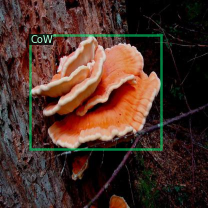

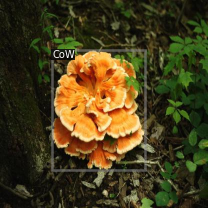

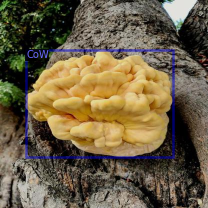

In [9]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [10]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [11]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/17 18:14:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:10, 40.3MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/17 18:14:17 d2.engine.train_loop]: Starting training from iteration 0
[11/17 18:14:54 d2.utils.events]:  eta: 0:47:42  iter: 19  total_loss: 2.428  loss_cls: 1.502  loss_box_reg: 0.903  loss_rpn_cls: 0.005  loss_rpn_loc: 0.007  time: 1.8752  data_time: 0.0359  lr: 0.000020  max_mem: 7206M
[11/17 18:15:31 d2.utils.events]:  eta: 0:46:26  iter: 39  total_loss: 2.056  loss_cls: 1.157  loss_box_reg: 0.885  loss_rpn_cls: 0.005  loss_rpn_loc: 0.006  time: 1.8758  data_time: 0.0141  lr: 0.000040  max_mem: 7206M
[11/17 18:16:11 d2.utils.events]:  eta: 0:46:32  iter: 59  total_loss: 1.590  loss_cls: 0.682  loss_box_reg: 0.891  loss_rpn_cls: 0.003  loss_rpn_loc: 0.005  time: 1.9106  data_time: 0.0153  lr: 0.000060  max_mem: 7206M
[11/17 18:16:50 d2.utils.events]:  eta: 0:46:03  iter: 79  total_loss: 1.421  loss_cls: 0.535  loss_box_reg: 0.890  loss_rpn_cls: 0.003  loss_rpn_loc: 0.005  time: 1.9260  data_time: 0.0175  lr: 0.000080  max_mem: 7206M
[11/17 18:17:32 d2.utils.events]:  eta: 0:46:0

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [12]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [11/17 19:10:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/17 19:10:09 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/test/_annotations.coco.json
[11/17 19:10:09 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|  mushroom  | 0            |    CoW     | 1            | chanterelle | 8            |
|            |              |            |              |             |              |
|   total    | 9            |            |              |             |              |
[11/17 19:10:09 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[11/17 19:10:09 d2.data.common]: Serialized dataset takes 0.00 MiB
[11/17 19:10:09 d2.evaluation.evaluator]: Start inference on 5

OrderedDict([('bbox',
              {'AP': 90.89232673267327,
               'AP50': 92.01732673267327,
               'AP75': 92.01732673267327,
               'APs': nan,
               'APm': nan,
               'APl': 90.89232673267327,
               'AP-mushroom': nan,
               'AP-CoW': 99.99999999999997,
               'AP-chanterelle': 81.78465346534654})])

# Inference with Detectron2 Saved Weights



In [13]:
%ls ./output/

coco_instances_results.json                       last_checkpoint
events.out.tfevents.1668708846.64bb3f4819f2.79.0  metrics.json
instances_predictions.pth                         model_final.pth


In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

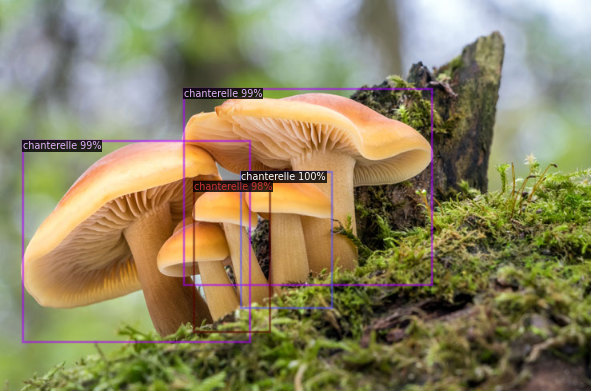

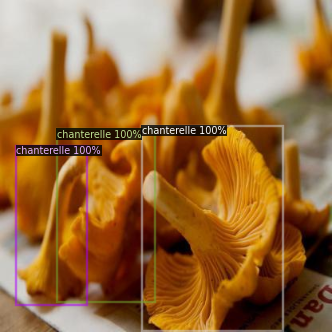

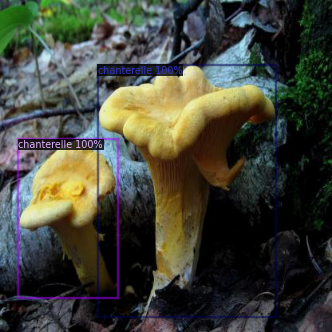

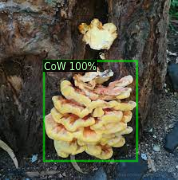

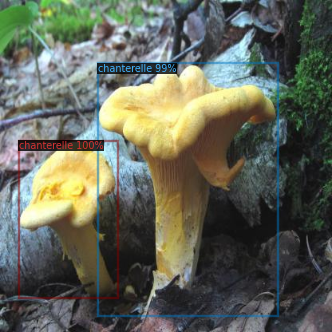

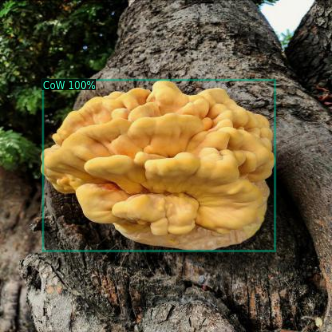

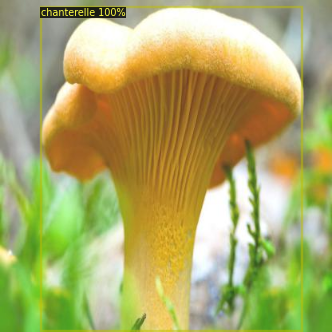

In [27]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')